In [1]:
import os
os.chdir('../')

In [2]:
from rsna_retro.imports import *
from rsna_retro.metadata import *
from rsna_retro.preprocess import *
from rsna_retro.train import *
from rsna_retro.train3d import *
from rsna_retro.seutao import *

Loading imports


In [3]:
dls = get_seutao_dls_meta(Meta.df_comb1, np_file, csv_file, bs=64)

loading features
Done loading features


In [4]:
torch.cuda.set_device(0)

## Load

In [5]:
class NeuralNet(nn.Module):
    def __init__(self, n_classes=6, sz=2048+6+1, DO = 0.3):
        super(NeuralNet, self).__init__()
        
#         d_model = 2048+6+1
        
#         self.embedding_dropout = SpatialDropout(0.0) #DO)
        self.sz = sz
        self.lstm1 = nn.LSTM(sz, sz, bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(sz * 2, sz, bidirectional=True, batch_first=True)

        self.linear1 = nn.Linear(sz*2, sz*2)
        self.linear2 = nn.Linear(sz*2, sz*2)

        self.linear = nn.Linear(sz*2, n_classes)

    def forward(self, x):
        x = torch.cat(x, axis=-1)
        h_embedding = x

        h_embadd = torch.cat((h_embedding, h_embedding), -1)
        
        h_lstm1, _ = self.lstm1(h_embedding)
        h_lstm2, _ = self.lstm2(h_lstm1)
        
        h_conc_linear1  = F.relu(self.linear1(h_lstm1))
        h_conc_linear2  = F.relu(self.linear2(h_lstm2))
        
#         print([x.shape for x in [h_lstm1, h_lstm2, h_conc_linear1, h_conc_linear2, h_embadd]])
        
        hidden = h_lstm1 + h_lstm2 + h_conc_linear1 + h_conc_linear2 + h_embadd

        output = self.linear(hidden)
        
        return output

In [6]:
m = NeuralNet().cuda()

In [7]:
learn = get_learner(dls, m)

In [8]:
name = 'seutao_feat_2nd_place_meta'

In [9]:
learn.add_cb(DePadLoss())
# learn.add_cb(SaveModelCallback(name))

## Train

/home/ashaw/anaconda3/envs/rsna_retro/lib/python3.7/site-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


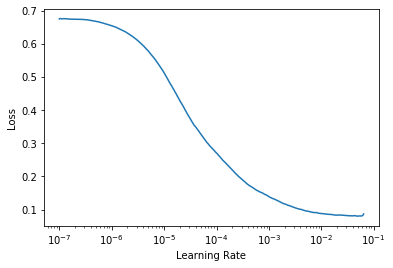

In [10]:
learn.lr_find(num_it=500)

In [10]:
do_fit(learn, 10, 1e-2)
learn.save(f'runs/{name}-1')

epoch,train_loss,valid_loss,accuracy_multi,accuracy_any,time
0,0.065730,None,None,None,02:18
1,0.064177,None,None,None,02:20
2,0.064490,None,None,None,02:20
3,0.064036,None,None,None,02:20
4,0.063420,None,None,None,02:20
5,0.057619,None,None,None,02:20
6,0.058940,None,None,None,02:20
7,0.054802,None,None,None,02:20
8,0.053725,None,None,None,02:20
9,0.052202,None,None,None,02:20


/home/ashaw/anaconda3/envs/rsna_retro/lib/python3.7/site-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


## Submit

In [11]:
submit_predictions(learn, f'runs/{name}-1', f'subm/{name}', 'seutao meta features', dfunc=get_seutao_dls_meta)

loading features
Done loading features


100%|██████████| 26.0M/26.0M [00:03<00:00, 7.36MB/s]


In [13]:
api.competitions_submissions_list('rsna-intracranial-hemorrhage-detection')[0]

{'ref': 14352205,
 'totalBytes': 27277209,
 'date': '2020-02-01T16:28:09.59Z',
 'description': 'seutao meta features',
 'errorDescription': None,
 'fileName': 'seutao_feat_2nd_place_meta.csv',
 'publicScore': '0.84627',
 'privateScore': '0.04684',
 'status': 'complete',
 'submittedBy': 'Andrew Shaw',
 'submittedByRef': 'bearpelican',
 'teamName': 'Andrew Shaw',
 'type': 'standard',
 'url': 'https://www.kaggle.com/submissions/14352205/14352205.raw'}